In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


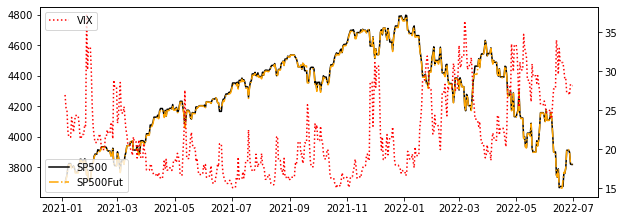

,Date,Close_SP,Close_VIX,Close_SPF
0,2021-01-04,3700.649902,26.969999,3692.25
1,2021-01-05,3726.860107,25.340000,3718.25
2,2021-01-06,3748.139893,25.070000,3740.50


In [48]:
#Ini_date="2019-01-01"
#Ini_date="2020-01-01"
Ini_date="2021-01-01"
IniStg_date="2022-01-01"
End_date="2022-06-30"

VIX_db = yf.download("^VIX", start=Ini_date, end=End_date)
#print(VIX_db[:3])
SP500Fut_db = yf.download("ES=F", start=Ini_date, end=End_date)
#print(SP500Fut_db[:3])
SP500_db = yf.download("^GSPC", start=Ini_date, end=End_date)
#print(SP500_db[:3])

VIX_db=pd.DataFrame(VIX_db['Close'])
SP500Fut_db=pd.DataFrame(SP500Fut_db['Close'])
SP500_db=pd.DataFrame(SP500_db['Close'])

VIX_db.reset_index(inplace=True)
VIX_db = (VIX_db.set_index('Date')
      .reindex(pd.date_range(Ini_date, End_date, freq='D'))
      .rename_axis(['Date'])
      .fillna(method='ffill')
      .dropna()
      .reset_index())

SP500Fut_db.reset_index(inplace=True)
SP500Fut_db = (SP500Fut_db.set_index('Date')
      .reindex(pd.date_range(Ini_date, End_date, freq='D'))
      .rename_axis(['Date'])
      .fillna(method='ffill')
      .dropna()
      .reset_index())

SP500_db.reset_index(inplace=True)
SP500_db = (SP500_db.set_index('Date')
      .reindex(pd.date_range(Ini_date, End_date, freq='D'))
      .rename_axis(['Date'])
      .fillna(method='ffill')
      .dropna()
      .reset_index())


fig, ax1 = plt.subplots(figsize=(10,3.5))
ax2 = ax1.twinx()
ax1.plot(SP500_db['Date'], SP500_db['Close'],label = "SP500", color='black')
ax1.plot(SP500_db['Date'], SP500Fut_db['Close'], label = "SP500Fut",linestyle='dashdot', color='orange')
ax2.plot(SP500_db['Date'], VIX_db['Close'],  label ="VIX",linestyle='dotted', color='red')
ax1.legend(loc='lower left')
ax2.legend(loc='upper left')
plt.show()


MergedData= pd.concat(
    objs=(iDF.set_index('Date') for iDF in (SP500_db,VIX_db, SP500Fut_db)),
    axis=1, 
    join='inner'
).reset_index()
MergedData.columns=['Date','Close_SP','Close_VIX','Close_SPF']
MergedData.head(3)



In [49]:
#Separate dates for future plotting
df=MergedData.loc[MergedData['Date'] < '2022-01-01'].copy()
train_dates = df['Date']
#Variables for training
cols=list(df)[1:4]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']
#New dataframe with only training data - 3 columns
df_for_training = df[cols].astype(float)

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

['Close_SP', 'Close_VIX', 'Close_SPF']


In [50]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 9  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0]) #SP500 column

In [51]:
print(len(trainX))
print(len(trainX[0]))
print(len(trainX[0][0]))

353
9
3


In [52]:
trainX, trainY = np.array(trainX), np.array(trainY)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (353, 9, 3).
trainY shape == (353, 1).


In [318]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

In [53]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 9, 64)             17408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [54]:

# fit the model
history = model.fit(trainX, trainY, epochs=40, batch_size=7, validation_split=0.2, verbose=1)

Epoch 1/40
41/41 [==============================] - 4s 15ms/step - loss: 0.3083 - val_loss: 0.0587
Epoch 2/40
41/41 [==============================] - 0s 6ms/step - loss: 0.0738 - val_loss: 0.0504
Epoch 3/40
41/41 [==============================] - 0s 6ms/step - loss: 0.0477 - val_loss: 0.0795
Epoch 4/40
41/41 [==============================] - 0s 6ms/step - loss: 0.0467 - val_loss: 0.0657
Epoch 5/40
41/41 [==============================] - 0s 6ms/step - loss: 0.0410 - val_loss: 0.0451
Epoch 6/40
41/41 [==============================] - 0s 6ms/step - loss: 0.0373 - val_loss: 0.0397
Epoch 7/40
41/41 [==============================] - 0s 7ms/step - loss: 0.0469 - val_loss: 0.1120
Epoch 8/40
41/41 [==============================] - 0s 6ms/step - loss: 0.0453 - val_loss: 0.0940
Epoch 9/40
41/41 [==============================] - 0s 6ms/step - loss: 0.0505 - val_loss: 0.0845
Epoch 10/40
41/41 [==============================] - 0s 6ms/step - loss: 0.0424 - val_loss: 0.0450
Epoch 11/40
41/41 

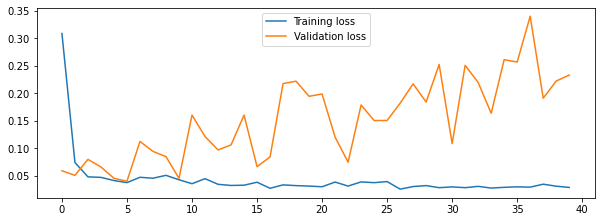

In [55]:
plt.figure(figsize=(10,3.5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [56]:

#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 1
n_days_for_prediction=1  #let us predict past 15 days

In [57]:
predict_period_dates = pd.date_range(list(train_dates)[-1], periods=n_days_for_prediction+1, freq='1d').tolist()[-1]
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


2022-01-01 00:00:00
1/1 [==============================] - 0s 319ms/step


In [58]:

# Convert timestamp to date
forecast_dates = []
#for time_i in predict_period_dates:
#    forecast_dates.append(time_i.date())
forecast_dates.append(predict_period_dates.date())
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


        Date         Open
0 2022-01-01  4664.655762


C:\Users\Edwin\AppData\Local\Temp\ipykernel_3196\1538790338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will 

<AxesSubplot:xlabel='Date', ylabel='Close_SP'>

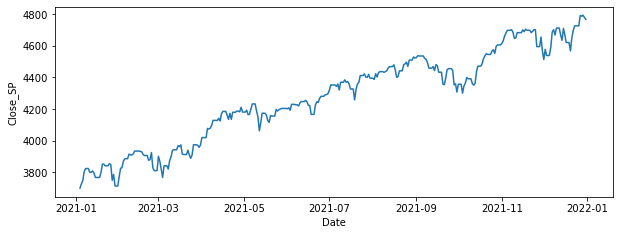

In [59]:
original = df[['Date', 'Close_SP']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

print(df_forecast)
plt.figure(figsize=(10,3.5))
sns.lineplot(original['Date'], original['Close_SP'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])


In [60]:
n_past=9

date_1 = datetime.strptime(IniStg_date, '%Y-%m-%d')
result_1 = date_1 - timedelta(days=n_past)
StgyPredDf=MergedData.loc[MergedData['Date'] >= result_1].copy()
StgyPredDf.reset_index(inplace=True)
StgyPredDf['Pred']=np.nan
StgyPredDf.drop(['index'], axis=1,inplace=True)

In [61]:
cols=list(StgyPredDf)[1:4]
df_for_pred = StgyPredDf[cols].astype(float)
scaler2 = StandardScaler()
scaler2 = scaler2.fit(df_for_pred)
df_for_pred_scaled = scaler2.transform(df_for_pred)

PredX=[]
PredY=[]


for i in range(n_past, len(df_for_pred_scaled) - n_future +1):
    PredX.append(df_for_pred_scaled[i - n_past:i, 0:df_for_pred.shape[1]])
    PredY.append(df_for_pred_scaled[i + n_future - 1:i + n_future, 0]) #SP500 column

In [62]:
PredX, PredY = np.array(PredX), np.array(PredY)
print('PredX shape == {}.'.format(PredX.shape))
print('PredY shape == {}.'.format(PredY.shape))

PredX shape == (181, 9, 3).
PredY shape == (181, 1).


In [63]:
for i in range(len(StgyPredDf)):
    if i >=n_past:
        #Make prediction
        prediction = model.predict(PredX[i-n_past:i-n_past+1])
        prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
        StgyPredDf.loc[i,'Pred']=scaler2.inverse_transform(prediction_copies)[:,0]

1/1 [==============================] - 0s 18ms/step


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Pred'>

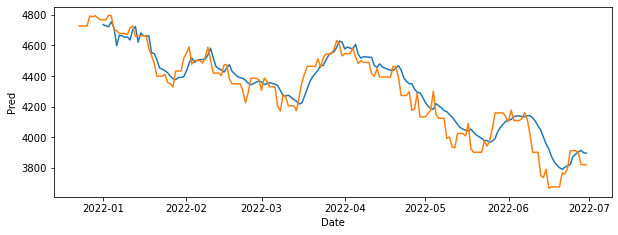

In [64]:
plt.figure(figsize=(10,3.5))
sns.lineplot(StgyPredDf['Date'], StgyPredDf['Pred'])
sns.lineplot(StgyPredDf['Date'], StgyPredDf['Close_SP'])

In [204]:
#StgyPredDf.to_excel("RawDataLTSM.xlsx")

In [65]:
StgyDf=StgyPredDf.dropna().copy()
StgyDf.reset_index(inplace=True)
StgyDf.drop(['index'], axis=1,inplace=True)
StgyDf['Ret']=StgyDf['Close_SP']/StgyDf['Close_SP'].shift(1)-1
StgyDf['Signal']=np.sign(StgyDf['Pred']-StgyDf['Close_SP'])
StgyDf['InvestVal']=np.nan
StgyDf['InvestOp']=np.nan
StgyDf['StrgRet']=0
StgyDf['StrgDecitions']=np.nan

In [66]:
DecCount=0
for i in range(len(StgyDf)):
    
    if i>0:
        #last signal sell
        if  np.isnan(StgyDf.loc[i,'InvestOp'])!=True and StgyDf.loc[i-1,'StrgDecitions']=='sell':
            StgyDf.loc[i,'StrgDecitions']='sell'
            StgyDf.loc[i,'InvestVal']=StgyDf.loc[i-1,'InvestVal']
            ##print(StgyDf[i-1:i+2])
        elif np.isnan(StgyDf.loc[i,'InvestOp'])==True and StgyDf.loc[i-1,'StrgDecitions']=='sell':
            StgyDf.loc[i,'StrgDecitions']='sell'
            StgyDf.loc[i,'InvestOp']=StgyDf.loc[i-1,'InvestOp']
            StgyDf.loc[i,'InvestVal']=StgyDf.loc[i-1,'InvestVal']
            ##print(StgyDf[i-1:i+2])
        #last signal buy
        if np.isnan(StgyDf.loc[i,'InvestOp'])!=True and StgyDf.loc[i-1,'StrgDecitions']=='buy':
            StgyDf.loc[i,'StrgDecitions']='buy'
            StgyDf.loc[i,'InvestVal']=StgyDf.loc[i-1,'InvestVal']*(1+StgyDf.loc[i,'Ret'])
            ##print(StgyDf[i-1:i+2])
        elif np.isnan(StgyDf.loc[i,'InvestOp'])==True and StgyDf.loc[i-1,'StrgDecitions']=='buy':
            StgyDf.loc[i,'StrgDecitions']='buy'
            StgyDf.loc[i,'InvestOp']=StgyDf.loc[i-1,'InvestOp']
            StgyDf.loc[i,'InvestVal']=StgyDf.loc[i-1,'InvestVal']*(1+StgyDf.loc[i,'Ret'])
            ##print(StgyDf[i-1:i+2])
    #print(np.isnan(StgyDf.loc[i,'InvestOp']))
  #Strategy returns calculation
    if np.isnan(StgyDf.loc[i,'InvestOp'])==True:
        StgyDf.loc[i,'StrgRet']=0
    else:
        StgyDf.loc[i,'StrgRet']=StgyDf.loc[i,'InvestVal']/StgyDf.loc[i,'InvestOp']-1
    #buys
    if StgyDf.loc[i,'Signal']==1:
        if DecCount==0:
            StgyDf.loc[i,'StrgDecitions']='buy'
            StgyDf.loc[i,'InvestVal']=1
            StgyDf.loc[i,'InvestOp']=StgyDf.loc[i,'InvestVal']
            StgyDf.loc[i+1,'InvestOp']=StgyDf.loc[i,'InvestVal']
            StgyDf.loc[i,'StrgRet']=StgyDf.loc[i,'InvestVal']/StgyDf.loc[i,'InvestOp']-1
            ##print(StgyDf[i-1:i+2])
            DecCount+=1
        elif DecCount !=0 and StgyDf.loc[i,'Signal']==1 and StgyDf.loc[i-1,'StrgDecitions']=='sell':
            StgyDf.loc[i,'StrgDecitions']='buy'
            StgyDf.loc[i,'InvestOp']=StgyDf.loc[i-1,'InvestOp']
            StgyDf.loc[i,'InvestVal']=StgyDf.loc[i,'InvestOp']
            StgyDf.loc[i+1,'InvestOp']=StgyDf.loc[i,'InvestVal']
            StgyDf.loc[i+1,'InvestOp']=StgyDf.loc[i,'InvestVal']
            StgyDf.loc[i,'StrgRet']=StgyDf.loc[i,'InvestVal']/StgyDf.loc[i,'InvestOp']-1
            ##print(StgyDf[i-1:i+2])
            DecCount+=1
            
      #print(Stgy_DF.loc[i-1,'StrgDecitions']=='buy')
    if DecCount>0 and StgyDf.loc[i,'Signal']==-1:
    #sell
        if StgyDf.loc[i-1,'StrgDecitions']=='buy':
            StgyDf.loc[i,'StrgDecitions']='sell'
            StgyDf.loc[i,'InvestOp']=StgyDf.loc[i-1,'InvestOp']
            StgyDf.loc[i,'InvestVal']=StgyDf.loc[i-1,'InvestVal']*(1+StgyDf.loc[i,'Ret'])
            StgyDf.loc[i+1,'InvestOp']=StgyDf.loc[i,'InvestVal']
            StgyDf.loc[i,'StrgRet']=StgyDf.loc[i,'InvestVal']/StgyDf.loc[i,'InvestOp']-1
            ##print(StgyDf[i-1:i+2])
            DecCount=+1
StgyDf['InvestVal'].bfill(inplace=True)
    

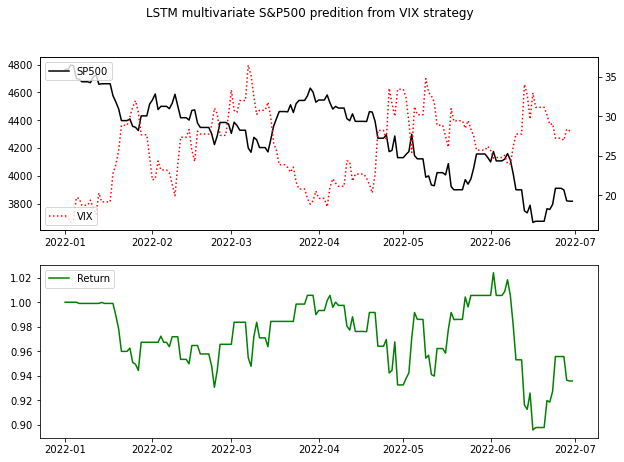

In [67]:
fig, axs = plt.subplots(2,figsize=(10,7))
fig
fig.suptitle('LSTM multivariate S&P500 predition from VIX strategy')
axs0=axs[0].twinx()
axs[0].plot(StgyDf['Date'], StgyDf['Close_SP'], color='black',label='SP500') 
axs0.plot(StgyDf['Date'], StgyDf['Close_VIX'], color='red',label='VIX',linestyle='dotted')
axs[1].plot(StgyDf['Date'],StgyDf['InvestVal'], color='green',label='Return')
axs[0].legend(loc='upper left')
axs0.legend(loc='lower left')
axs[1].legend(loc='upper left')
plt.show()

In [25]:
Stgy_DF_19=StgyDf.copy()

In [47]:
Stgy_DF_20=StgyDf.copy()

In [68]:
Stgy_DF_21=StgyDf.copy()

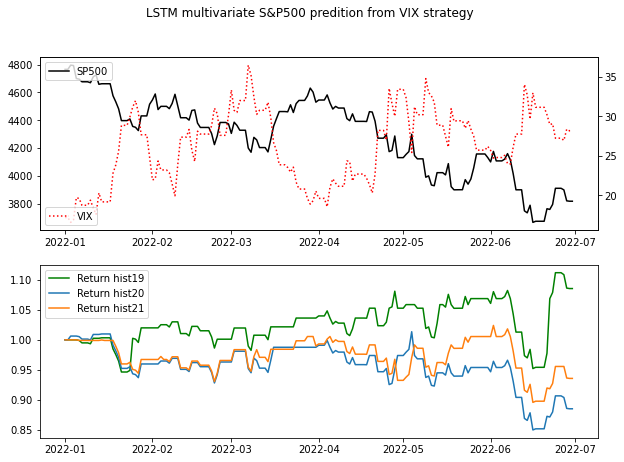

In [70]:
fig, axs = plt.subplots(2,figsize=(10,7))
fig
fig.suptitle('LSTM multivariate S&P500 predition from VIX strategy')
axs0=axs[0].twinx()
axs[0].plot(StgyDf['Date'], StgyDf['Close_SP'], color='black',label='SP500') 
axs0.plot(StgyDf['Date'], StgyDf['Close_VIX'], color='red',label='VIX',linestyle='dotted')
axs[1].plot(StgyDf['Date'],Stgy_DF_19['InvestVal'], color='green',label='Return hist19')
axs[1].plot(StgyDf['Date'],Stgy_DF_20['InvestVal'], label='Return hist20')
axs[1].plot(StgyDf['Date'],Stgy_DF_21['InvestVal'], label='Return hist21')
axs[0].legend(loc='upper left')
axs0.legend(loc='lower left')
axs[1].legend(loc='upper left')
plt.show()

In [72]:
1-0.9357

0.06430000000000002

In [73]:
  
# initialize list of lists
data = [['>2019', 0.0855], ['>2020', -0.1149], ['>2021', -0.0643]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Range', 'Return'])
  
# print dataframe.
df

,Range,Return
0,>2019,0.0855
1,>2020,-0.1149
2,>2021,-0.0643


In [74]:
df

,Range,Return
0,>2019,0.0855
1,>2020,-0.1149
2,>2021,-0.0643


In [75]:
df.T

,0,1,2
Range,>2019,>2020,>2021
Return,0.0855,-0.1149,-0.0643
